# **3D Medical Image Segmentation with U-Net**


# **1. Introduction:**

In this project, we aim to develop an automated method for segmenting the hippocampus subfields in brain images using the Task4 dataset. Our focus is on leveraging the U-Net architecture, a well-regarded model in medical image segmentation. We will experiment with various configurations and data preprocessing techniques, including 3D modeling. The goal is to create a robust model that accurately identifies hippocampus subfields, contributing to advancements in medical imaging and enhancing the understanding and treatment of neurological disorders.

The project will explore various enhancements and configurations of U-Net, including:
*   Environment Setup and Library Imports
*   Data Loading
*   Data Visualization
*   Data Preprocessing: Several preprocessing techniques were applied, such as padding, Contrast Limited Adaptive Histogram Equalization (CLAHE), and normalization, to prepare the data for optimal training results.
*   3D U-Net Model for Segmentation: A 3D U-Net model was constructed to be trained on volumetric images.
*   Model Training: The 3D U-Net model was trained on both the enhanced and original datasets to evaluate which approach yields better performance in this context.
*   Prediction: The trained model was used to make predictions on new data, assessing its segmentation accuracy.


##**2. Environment Setup and Library Imports**




In [ ]:
import os                     # For handling file paths and directories
import nibabel as nib         # For loading neuroimaging data in NIfTI format
import matplotlib.pyplot as plt  # For plotting images and graphs
import random                 # For random number generation
import numpy as np            # For numerical operations on arrays
import cv2                    # For image processing tasks
import tensorflow as tf       # For building and training neural network models

# Importing specific layers and models from Keras for constructing the U-Net model
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, Conv3DTranspose,
                                     concatenate, Dropout, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal  # Initializer for the model weights
from tensorflow.keras.models import load_model     # For loading a saved model
from tensorflow.keras.utils import plot_model

# For mounting Google Colab drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Data Loading**

## 2.1 Loading Matched NIfTI Files

This function, **load_matched_nifti_files**, is designed to load image and mask data from specified directories. It assumes that the image and its corresponding mask have the same filename, a common convention in medical image datasets. After matching, it loads the NIfTI files and appends their data to respective lists.

In [ ]:
def load_matched_nifti_files(image_directory_path, mask_directory_path):
    """
    Load and match NIfTI image files with their corresponding mask files.

    Args:
    image_directory_path (str): Path to the directory containing image files.
    mask_directory_path (str): Path to the directory containing mask files.

    Returns:
    matched_images (list): List of image data arrays.
    matched_masks (list): List of mask data arrays.
    """
    matched_images = []
    matched_masks = []

    # Get a list of image and mask files
    image_files = os.listdir(image_directory_path)
    mask_files = os.listdir(mask_directory_path)

    # Iterate over image files to find corresponding mask files
    for image_file in image_files:
        if image_file.endswith('.nii') or image_file.endswith('.nii.gz'):
            mask_file = image_file  # Assuming masks have the same naming convention

            if mask_file in mask_files:
                # Load image
                image_path = os.path.join(image_directory_path, image_file)
                nifti_image = nib.load(image_path)
                image_data = nifti_image.get_fdata()

                # Load mask
                mask_path = os.path.join(mask_directory_path, mask_file)
                nifti_mask = nib.load(mask_path)
                mask_data = nifti_mask.get_fdata()

                # Append matched image and mask
                matched_images.append(image_data)
                matched_masks.append(mask_data)

    return matched_images, matched_masks

# Define the paths to the image and mask directories
image_directory_path = '/content/drive/MyDrive/Hippocampus/Task04_Hippocampus/imagesTr'
mask_directory_path = '/content/drive/MyDrive/Hippocampus/Task04_Hippocampus/labelsTr'

# Load the matched images and masks
images, masks = load_matched_nifti_files(image_directory_path, mask_directory_path)


## 2.2 Verifying Shapes of Images and Masks

This function, **verify_shapes**, checks that each image has a corresponding mask of the same shape. This step is crucial to ensure data consistency before proceeding with further processing and model training. The assertions will throw an error if there is a mismatch, helping to catch potential issues early in the pipeline.







In [ ]:
def verify_shapes(images, masks):
    """
    Verify that each image has a corresponding mask of the same shape.

    Args:
    images (list): List of image data arrays.
    masks (list): List of mask data arrays.
    """
    assert len(images) == len(masks), "The number of images and masks must be the same."

    for i in range(len(images)):
        assert images[i].shape == masks[i].shape, f"Shape mismatch at index {i}: Image shape {images[i].shape}, Mask shape {masks[i].shape}"

# Call the function to verify shapes
verify_shapes(images, masks)
print("All volumes and masks have the same shape.")


All volumes and masks have the same shape.


#**3. Visualize the Dataset**

This function **visualize_images_with_masks** is designed to display image slices alongside their corresponding mask slices from the hippocampus dataset.

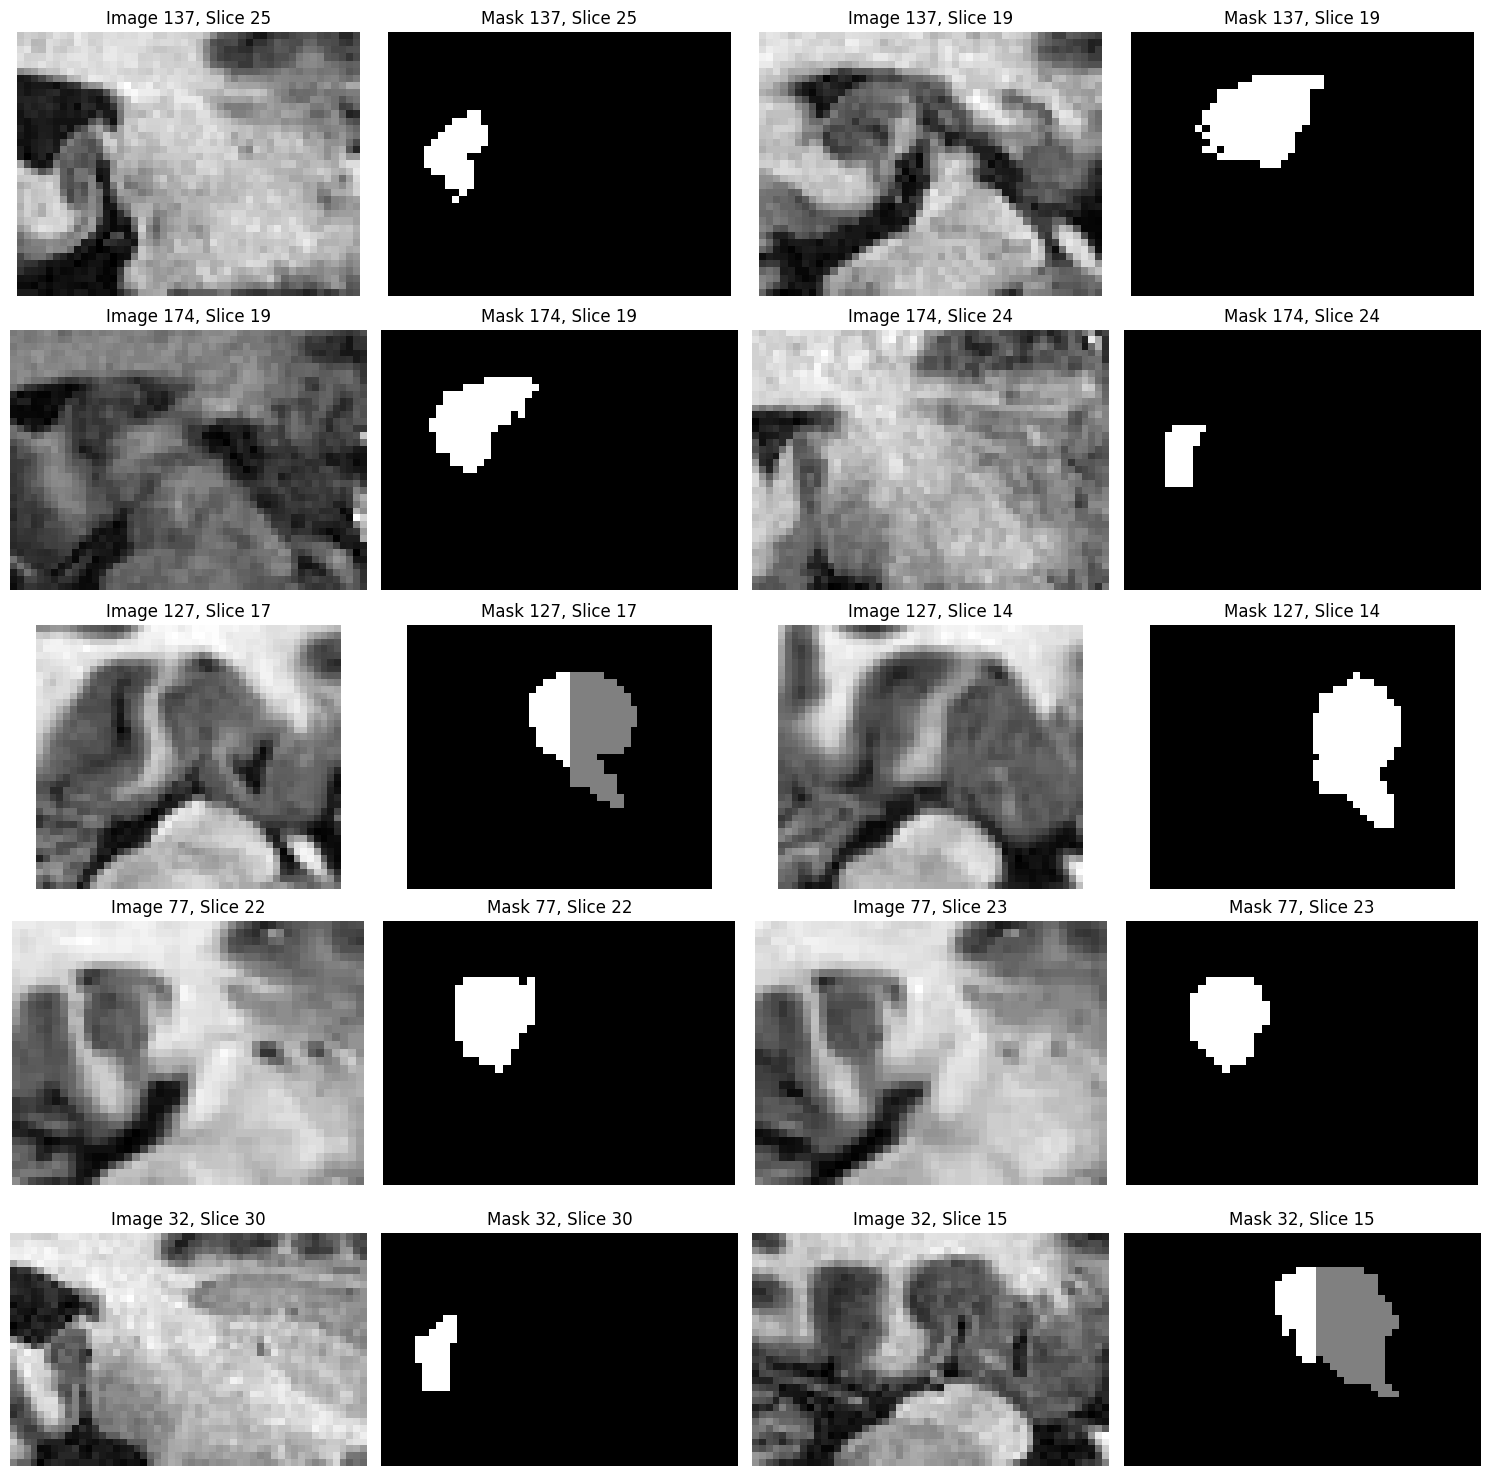

In [ ]:
def visualize_images_with_masks(images, masks, num_pairs=5, slices_per_pair=2, cmap='gray'):
    """
    Visualize a set of image slices with their corresponding mask slices.

    Parameters:
    images (list): List of 3D image volumes.
    masks (list): List of 3D mask volumes.
    num_pairs (int): Number of image-mask pairs to visualize.
    slices_per_pair (int): Number of slices to show per pair.
    cmap (str): Colormap to use for visualization.
    """
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(num_pairs, slices_per_pair * 2, figsize=(15, num_pairs * 3))

    for i in range(num_pairs):
        # Randomly select a pair of image and mask
        pair_idx = random.randint(0, len(images) - 1)
        image_volume = images[pair_idx]
        mask_volume = masks[pair_idx]

        for j in range(slices_per_pair):
            # Randomly select a slice from the selected pair
            slice_idx = random.randint(0, image_volume.shape[2] - 1)
            image_slice = image_volume[:, :, slice_idx]
            mask_slice = mask_volume[:, :, slice_idx]

            # Display the image slice
            ax_img = axes[i, j * 2] if num_pairs > 1 else axes[j * 2]
            ax_img.imshow(image_slice, cmap=cmap)
            ax_img.set_title(f'Image {pair_idx}, Slice {slice_idx}')
            ax_img.axis('off')

            # Display the corresponding mask slice
            ax_mask = axes[i, j * 2 + 1] if num_pairs > 1 else axes[j * 2 + 1]
            ax_mask.imshow(mask_slice, cmap=cmap)
            ax_mask.set_title(f'Mask {pair_idx}, Slice {slice_idx}')
            ax_mask.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize the images with their masks
# Make sure 'images' and 'masks' are loaded and available before calling this function.
visualize_images_with_masks(images, masks)



#**4. Data Preprocessing**

##4.1 Volume Shape Analysis and Padding


*   **Checking the Shape of Each Volume**


This code iterates through the list of image volumes, printing the shape of each volume. Understanding the shape of each volume is crucial in preprocessing, as it informs decisions regarding resizing and padding strategies to standardize the input size for the neural network.

In [ ]:
# Print the shape of each volume in the images list
for i, volume in enumerate(images):
    print(f"Shape of volume {i}: {volume.shape}")

Shape of volume 0: (35, 51, 35)
Shape of volume 1: (34, 52, 35)
Shape of volume 2: (36, 52, 38)
Shape of volume 3: (35, 52, 34)
Shape of volume 4: (36, 48, 40)
Shape of volume 5: (34, 47, 40)
Shape of volume 6: (36, 50, 31)
Shape of volume 7: (39, 50, 40)
Shape of volume 8: (35, 48, 32)
Shape of volume 9: (42, 51, 28)
Shape of volume 10: (36, 46, 43)
Shape of volume 11: (36, 47, 41)
Shape of volume 12: (38, 52, 33)
Shape of volume 13: (35, 51, 35)
Shape of volume 14: (36, 50, 36)
Shape of volume 15: (35, 48, 35)
Shape of volume 16: (36, 49, 40)
Shape of volume 17: (35, 47, 37)
Shape of volume 18: (33, 48, 38)
Shape of volume 19: (37, 51, 35)
Shape of volume 20: (34, 51, 32)
Shape of volume 21: (36, 47, 39)
Shape of volume 22: (37, 52, 34)
Shape of volume 23: (38, 48, 33)
Shape of volume 24: (36, 51, 34)
Shape of volume 25: (36, 48, 37)
Shape of volume 26: (36, 49, 38)
Shape of volume 27: (35, 51, 36)
Shape of volume 28: (38, 52, 29)
Shape of volume 29: (33, 54, 39)
Shape of volume 30: 

*   **Finding the Maximum Shape in the Dataset**

This function calculates the maximum shape dimensions among all image volumes. Knowing the largest volume dimensions is critical for setting a standard size across all images, which is necessary for consistent input to the U-Net model.

In [ ]:
def find_max_shape(volumes):
    """
    Determine the maximum shape among a list of volumes.

    Parameters:
    - volumes (list): A list of 3D volumes (numpy arrays).

    Returns:
    - max_shape (tuple): The maximum shape in the form of (Depth, Height, Width).
    """
    max_shape = (0, 0, 0)  # Initialize to minimum possible shape

    # Iterate through each volume to update the maximum shape
    for volume in volumes:
        max_shape = (
            max(max_shape[0], volume.shape[0]),
            max(max_shape[1], volume.shape[1]),
            max(max_shape[2], volume.shape[2])
        )

    return max_shape

# Apply this function to the list of images to find the maximum shape
max_shape = find_max_shape(images)
print(f"Maximum shape of the dataset: {max_shape}")


Maximum shape of the dataset: (43, 59, 47)


*   **Padding Volumes to a Target Shape**

This function applies padding to each volume so that they all match a specified target shape. We chose a target shape of (64, 64, 64) for padding the volumes primarily due to its compatibility with the U-Net architecture and computational efficiency. This size, being a power of two, aligns with the common practice in deep learning, facilitating seamless pooling and upsampling operations crucial in U-Net. It exceeds the maximum dataset dimensions of (43, 59, 47), ensuring no data loss, while also balancing the need for detail against computational resource constraints. Standardizing to this size provides uniformity across all samples, crucial for consistent neural network training and effective performance in segmentation tasks.

In [ ]:
def pad_volume_to_target_shape(volume, target_shape):
    """
    Pads a 3D volume to the given target shape.

    Parameters:
    - volume: numpy.ndarray, the original 3D volume to be padded.
    - target_shape: tuple, the desired shape (D, H, W) after padding.

    Returns:
    - padded_volume: numpy.ndarray, the volume after padding.
    """
    current_shape = volume.shape

    # Calculate the padding needed for each dimension
    padding = []
    for c, t in zip(current_shape, target_shape):
        delta = t - c
        # Padding for before and after the current dimension
        padding_before = delta // 2
        padding_after = delta - padding_before
        padding.append((padding_before, padding_after))

    # Apply padding
    padded_volume = np.pad(volume, padding, mode='constant', constant_values=0)

    return padded_volume

# Example usage:
# Assuming 'images' and 'masks' are lists of 3D numpy arrays
target_shape = (64, 64, 64)
padded_images = [pad_volume_to_target_shape(image, target_shape) for image in images]
padded_masks = [pad_volume_to_target_shape(mask, target_shape) for mask in masks]


*   **Visualization**

This function **visualize_padded_images** is designed to visually inspect a selection of padded images, focusing on their middle slices. For each chosen image, it displays several slices around the middle, giving an idea of how the padding looks across different parts of the image. The visualization is randomized to offer a diverse view from the dataset, and it's particularly useful for confirming that the padding process has been done correctly.

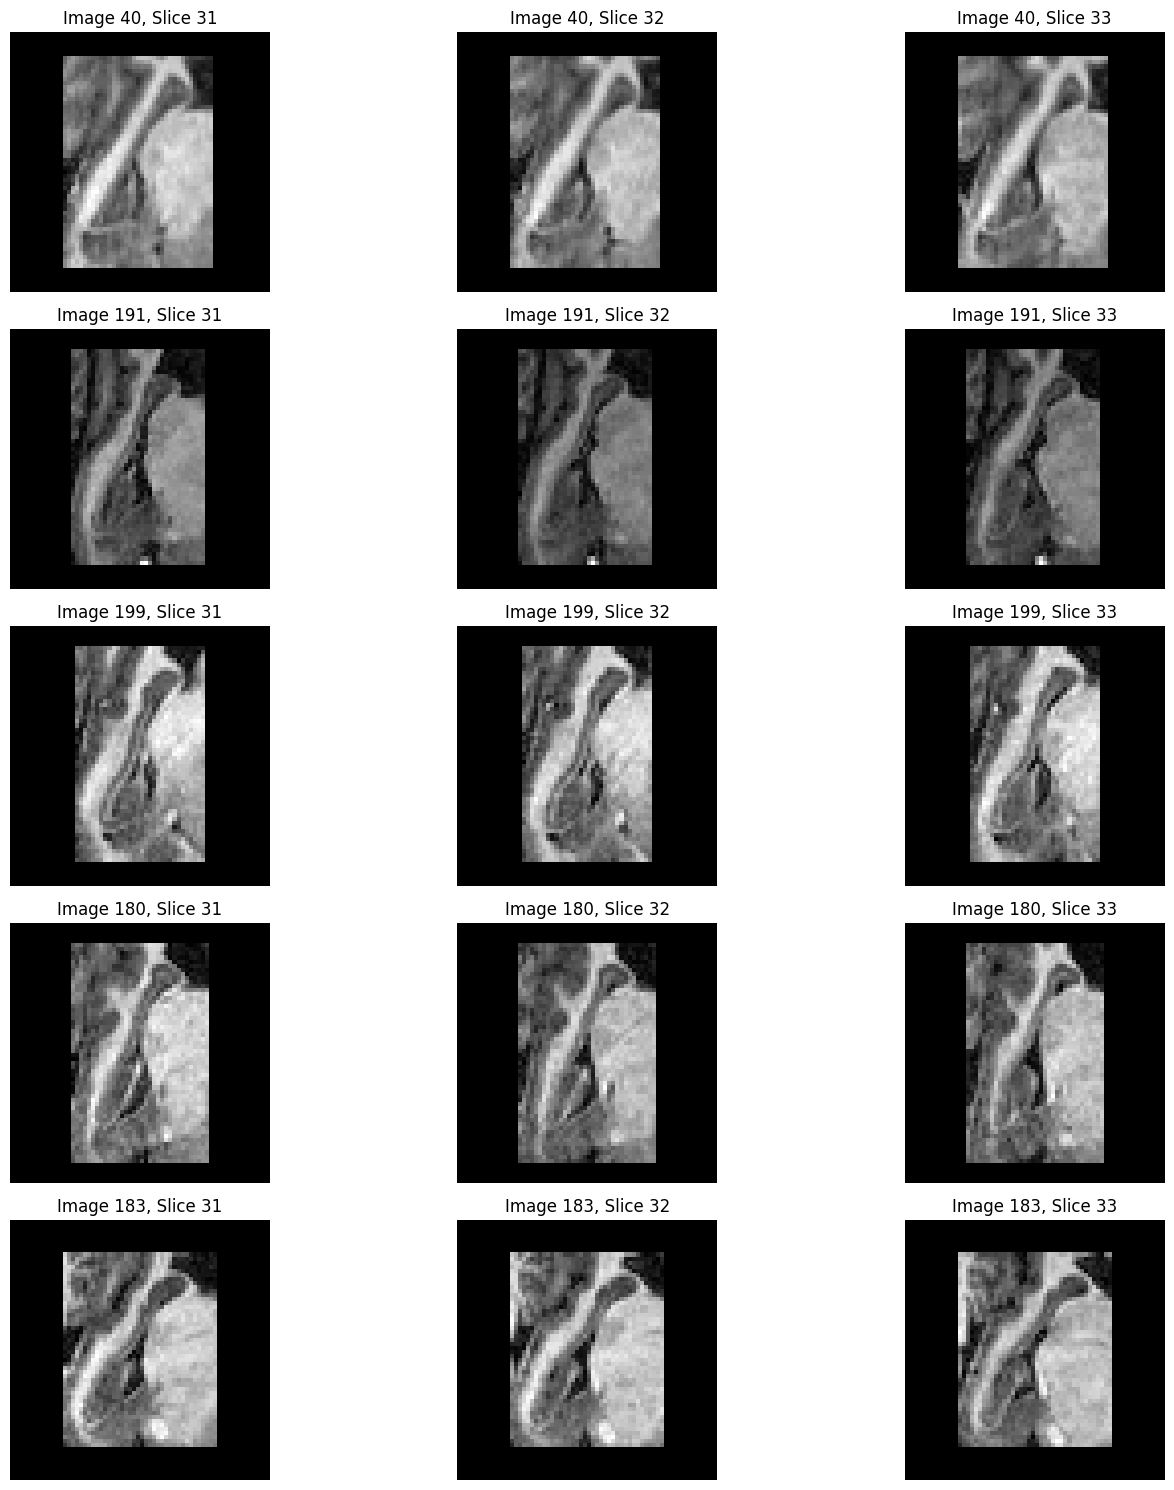

In [ ]:
def visualize_padded_images(images, num_images=5, slices_per_image=3, cmap='gray'):
    """
    Visualize middle slices from a set of padded images.

    Args:
    images (list): List of padded 3D image arrays.
    num_images (int): Number of images to visualize.
    slices_per_image (int): Number of slices to display per image.
    cmap (str): Colormap for visualization.
    """
    # Setting up the plot with specified number of images and slices
    fig, axes = plt.subplots(num_images, slices_per_image, figsize=(15, num_images * 3))

    for i in range(num_images):
        # Randomly select an image from the list
        image_idx = np.random.randint(0, len(images))
        image = images[image_idx]

        # Finding the middle slice index of the image
        mid_slice_idx = image.shape[0] // 2
        # Calculating indices for the slices to display around the middle slice
        slice_indices = np.linspace(mid_slice_idx - slices_per_image // 2,
                                    mid_slice_idx + slices_per_image // 2,
                                    slices_per_image, dtype=int)

        for j, slice_idx in enumerate(slice_indices):
            # Plot each slice
            ax = axes[i, j] if num_images > 1 else axes[j]
            ax.imshow(image[slice_idx, :, :], cmap=cmap)
            ax.set_title(f'Image {image_idx}, Slice {slice_idx}')
            ax.axis('off')  # Removing axis for cleaner visualization

    # Adjusting layout and displaying the plot
    plt.tight_layout()
    plt.show()

# Uncomment to visualize the padded images
visualize_padded_images(padded_images)


##4.2 Contrast Enhancement and Normalization

The function **apply_clahe_and_normalize** enhances the contrast and normalizes medical image volumes. It uses CLAHE (Contrast Limited Adaptive Histogram Equalization), a technique that improves local contrast in images, particularly useful for highlighting subtle features in medical scans. Each slice of the 3D volume is individually processed: CLAHE is applied after normalizing the slice to the range [0, 1]. Normalization is done by adjusting pixel values relative to the slice's minimum and maximum, ensuring that the entire volume has uniform brightness and contrast levels. This preprocessing step is chosen because it makes important features in medical images more pronounced and consistent, which is crucial for subsequent analysis or neural network training. It addresses issues like varying brightness and contrast in different slices, making the dataset more uniform and suitable for effective model training.

In [ ]:
def apply_clahe_and_normalize(volume, clip_limit=3.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE to a 3D volume and then normalize it.

    Args:
    volume (numpy.ndarray): A 3D array representing the medical image volume.
    clip_limit (float): Threshold for contrast limiting.
    tile_grid_size (tuple): Size of the grid for the histogram equalization.

    Returns:
    numpy.ndarray: The volume after applying CLAHE and normalization.
    """
    # Initialize the CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Prepare an array to store the enhanced volume
    enhanced_volume = np.zeros_like(volume, dtype=np.float32)

    # Apply CLAHE to each slice
    for i in range(volume.shape[2]):
        min_val = np.min(volume[:, :, i])
        max_val = np.max(volume[:, :, i])

        # Check if max and min values are the same (to avoid division by zero)
        if max_val > min_val:
            # Normalize the slice
            slice_normalized = (volume[:, :, i] - min_val) / (max_val - min_val)
            enhanced_slice = clahe.apply((slice_normalized * 255).astype('uint8'))
            enhanced_volume[:, :, i] = enhanced_slice / 255.0
        else:
            # If max and min are the same, just copy the original slice
            enhanced_volume[:, :, i] = volume[:, :, i]

    return enhanced_volume

# Apply CLAHE and normalization to all images
images_processed = [apply_clahe_and_normalize(volume) for volume in padded_images]


*   **Visulization**

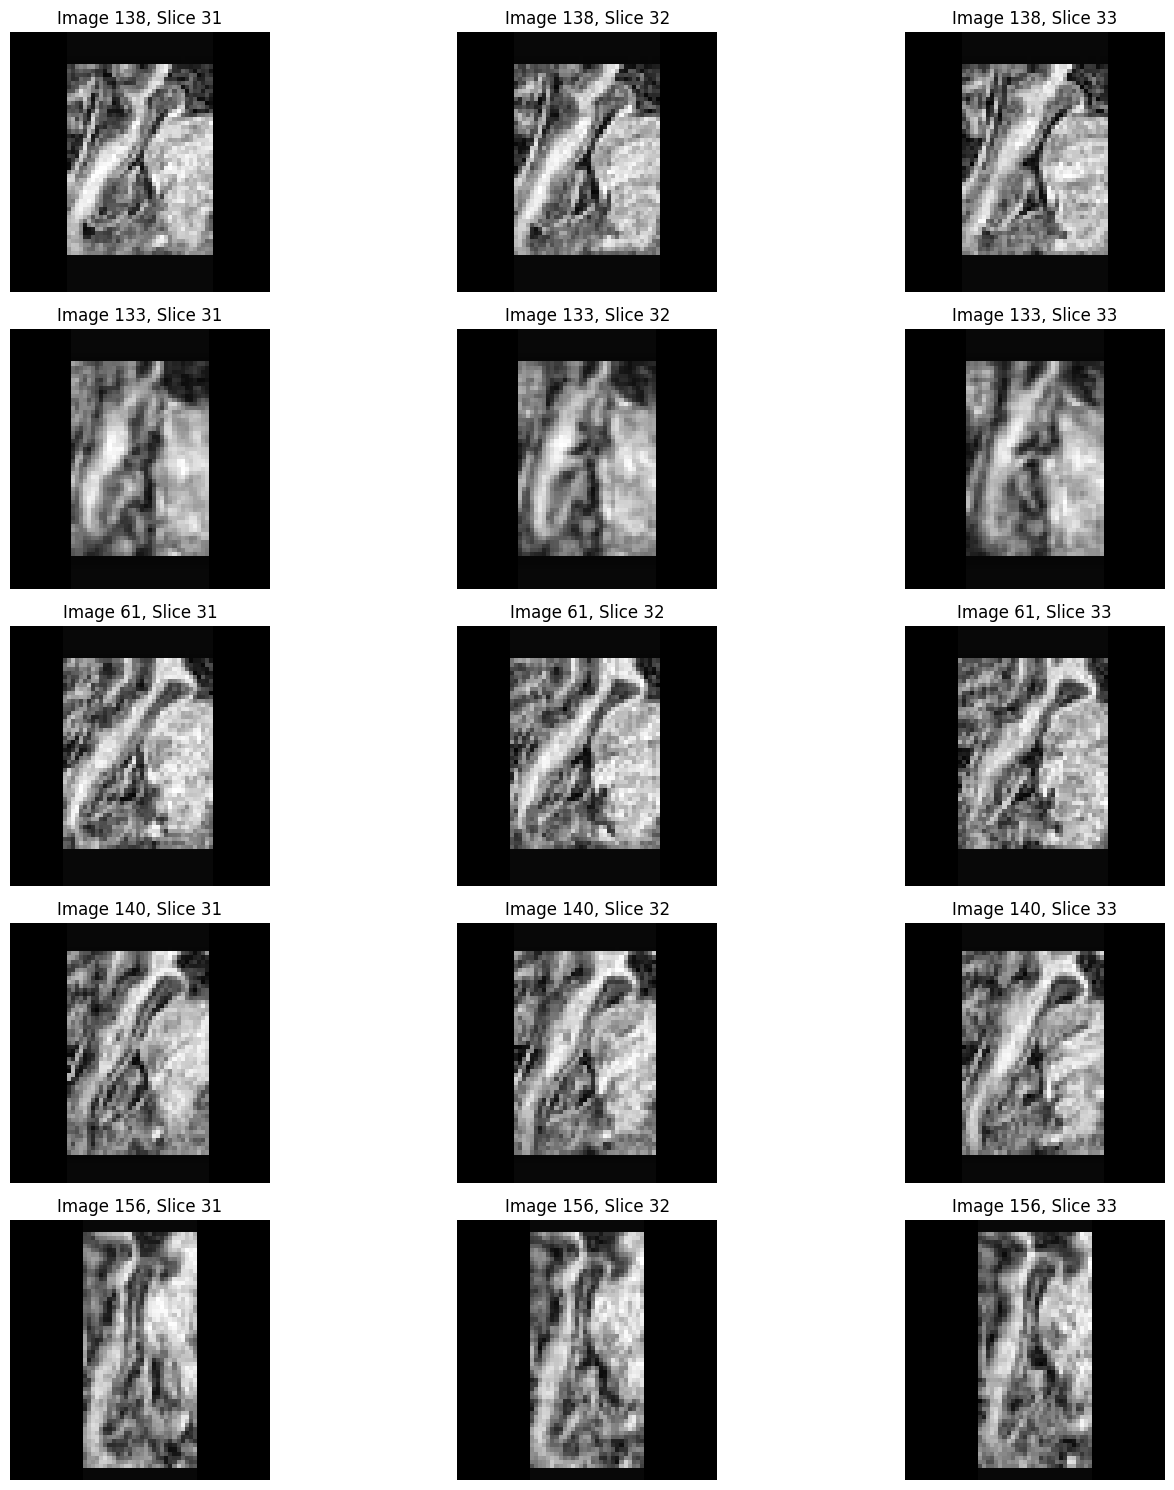

In [ ]:
visualize_padded_images(images_processed)

*   **Normalization**

In [ ]:
def normalize(volume):
    """
    Normalize the volume to a range of 0 to 1.

    Args:
    volume (numpy.ndarray): A 3D array representing the medical image volume.

    Returns:
    numpy.ndarray: The normalized volume.
    """
    # Finding the minimum and maximum values in the volume
    min = np.min(volume)
    max = np.max(volume)

    # Normalizing the volume
    # Subtracting the minimum value and dividing by the range (max - min)
    # This shifts the values to be within the range [0, 1]
    volume = (volume - min) / (max - min)
    return volume

# Applying the normalization function to each volume in the list of padded images
images_normalized = [normalize(volume) for volume in padded_images]


The normalize function standardizes the intensity values of image volumes to a 0-1 range, a key preprocessing step in medical image analysis. This normalization, achieved by adjusting each pixel value relative to the image's minimum and maximum values, ensures uniformity in contrast and brightness across different images. This process not only helps mitigate variations from diverse sources but also enhances neural network training efficiency. Once defined, this function is applied across all padded images, yielding a set of uniformly normalized images for subsequent processing or model training.







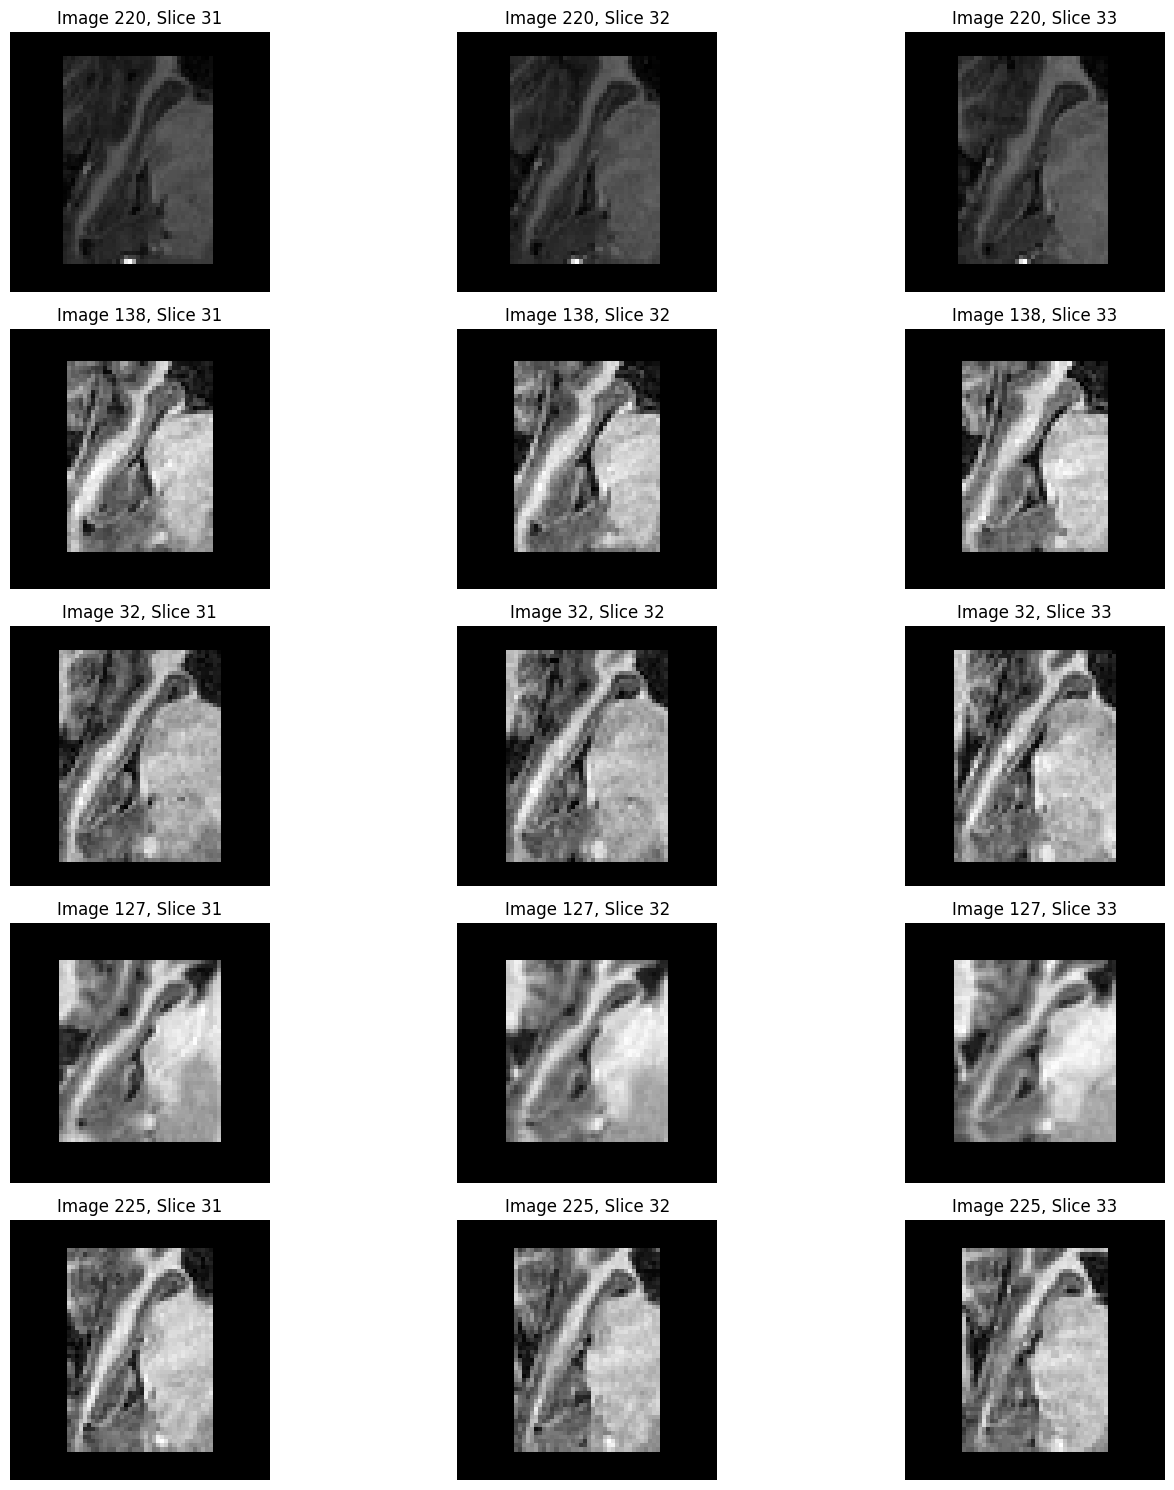

In [ ]:
visualize_padded_images(images_normalized)


##4.3 One-Hot Encoding for Masks


The **one_hot_encode_masks** function converts segmentation masks into a one-hot encoded format for multi-class segmentation with a 3D U-Net model. It remaps the intensity values in the masks to class indices and creates a new array with an additional dimension representing each class. This format is essential for neural network compatibility, especially for models requiring categorical targets, like in multi-class segmentation tasks. One-hot encoding facilitates clear class delineation and accurate loss computation during model training, making it a crucial step in preparing mask data for deep learning algorithms in medical image analysis.




In [ ]:
def one_hot_encode_masks(masks, num_classes=3):
    """
    One-hot encode the masks for training a 3D U-Net model.

    Parameters:
    masks (numpy.ndarray): Array of masks with shape (N, D, H, W),
                           where N is the number of volumes, D is the depth,
                           H is the height, and W is the width.
    num_classes (int): The number of distinct regions/classes.

    Returns:
    numpy.ndarray: One-hot encoded masks with shape (N, D, H, W, num_classes).
    """
    # Map the intensity values to class indices
    masks = np.where(masks == 128, 1, masks)
    masks = np.where(masks == 255, 2, masks)

    # Initialize the one-hot encoded array
    one_hot_encoded = np.zeros((*masks.shape, num_classes), dtype=np.int8)

    # Populate the one-hot encoded array
    for class_idx in range(num_classes):
        one_hot_encoded[..., class_idx] = (masks == class_idx)

    return one_hot_encoded

# Usage
# Assuming 'masks' is your array of mask volumes with the shape (N, D, H, W)
one_hot_encoded_masks = one_hot_encode_masks(padded_masks)


## **5. 3D U-Net Model for Segmentation**

In this notebook, we've tried to implement a 3D U Net model to segment the target region. The 3D U-Net is especially powerful for medical image analysis because it can process the full context of 3D images. It effectively captures spatial hierarchies and complex structures which are critical in medical diagnosis and analysis. The architecture's ability to operate on various scales and its use of skip connections to recover spatial resolution make it a robust choice for medical image segmentation tasks.







###5.1 Encoder (Downsampling Path)

The encoder consists of multiple blocks, each containing two 3D convolutional layers followed by a max-pooling layer. Each convolutional layer typically uses a kernel size of (3, 3, 3) and is followed by a ReLU activation function for non-linearity. The purpose of the encoder is to extract and downsample feature representations of the input volume. As the data passes through each block of the encoder, the spatial resolution decreases while the feature dimensionality increases.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """
    Encoder layer used in the U-Net architecture for downsampling the input.

    Attributes:
    num_filters (int): Number of filters for the convolutional layers.
    dropout (float): Dropout rate for regularization.
    conv1, conv2 (Conv3D): Convolutional layers with 'HeNormal' kernel initializer and 'same' padding.
    pool (MaxPooling3D): Max pooling layer for downsampling.
    relu (Activation): ReLU activation layer.
    """
    def __init__(self, num_filters, dropout=0.1, **kwargs):
        # Initialization code with convolutional layers, dropout, and max pooling
        super().__init__(**kwargs)
        self.conv1 = Conv3D(num_filters, (3, 3, 3), activation=None, kernel_initializer=HeNormal(), padding='same')
        self.dropout = Dropout(dropout)
        self.conv2 = Conv3D(num_filters, (3, 3, 3), activation=None, kernel_initializer=HeNormal(), padding='same')
        self.pool = MaxPooling3D((2, 2, 2))
        self.relu = Activation('relu')

    def call(self, inputs, training=False):
        # Processing inputs through convolutions, dropout, and pooling, then return them
        x = self.relu(self.conv1(inputs))
        x = self.dropout(x, training=training)
        x = self.relu(self.conv2(x))
        p = self.pool(x)
        return x, p


###5.2 Bottleneck

At the bottom of the U-Net architecture lies the bottleneck. This part of the network is designed to process the most abstract representations of the input data. It typically consists of two convolutional layers, often with a higher number of filters compared to the encoder layers. The bottleneck does not change the dimensionality of the data but focuses on extracting more complex features.

In [ ]:
class Bottleneck(tf.keras.layers.Layer):
    """
    Bottleneck layer of the U-Net architecture which acts as a bridge between the encoder and decoder pathways.

    Attributes:
    conv1, conv2 (Conv3D): Convolutional layers for deep feature extraction in the bottleneck.
    """
    def __init__(self, num_filters, dropout=0.3, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv3D(num_filters, (3, 3, 3), activation=None, kernel_initializer=HeNormal(), padding='same')
        self.dropout = Dropout(dropout)
        self.conv2 = Conv3D(num_filters, (3, 3, 3), activation=None, kernel_initializer=HeNormal(), padding='same')
        self.relu = Activation('relu')

    def call(self, inputs, training=False):
        x = self.relu(self.conv1(inputs))
        x = self.dropout(x, training=training)
        x = self.relu(self.conv2(x))
        return x


###5.3 Decoder (Upsampling Path)

The decoder mirrors the encoder structure but in reverse. It sequentially upsamples the feature maps using transposed convolutions (also known as deconvolutions) and concatenates them with the corresponding feature maps from the encoder path (skip connections). These skip connections provide the decoder with the context lost during downsampling. Each upsampling step is followed by two convolutional layers to refine the features.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    """
    Decoder layer used in the U-Net architecture for upsampling and merging feature maps.

    Attributes:
    up (Conv3DTranspose): Transposed convolutional layer for upsampling.
    concat (function): Function to concatenate feature maps.
    conv1, conv2 (Conv3D): Convolutional layers following the upsampling and concatenation.
    """
    def __init__(self, num_filters, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.up = Conv3DTranspose(num_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')
        self.concat = concatenate
        self.conv1 = Conv3D(num_filters, (3, 3, 3), activation=None, kernel_initializer=HeNormal(), padding='same')
        self.dropout = Dropout(dropout)
        self.conv2 = Conv3D(num_filters, (3, 3, 3), activation=None, kernel_initializer=HeNormal(), padding='same')
        self.relu = Activation('relu')

    def call(self, inputs, skip, training=False):
        x = self.up(inputs)
        x = self.concat([x, skip], axis=4)
        x = self.relu(self.conv1(x))
        x = self.dropout(x, training=training)
        x = self.relu(self.conv2(x))
        return x


###5.4 3D U-Net

   Assembles the complete 3D U-Net architecture by integrating the encoder, bottleneck, and decoder components. The model concludes with a final convolutional layer that maps the network's learned features to the desired number of class predictions. This output layer uses (1, 1, 1) convolutions for voxel-wise classification, employing a softmax activation function to output class probabilities for each voxel.

In [ ]:
def build_3d_unet(input_shape, num_classes):
    """
    Function to build the 3D U-Net model.

    Args:
    input_shape (tuple): Shape of the input volume.
    num_classes (int): Number of classes for segmentation.

    Returns:
    tf.keras.Model: The constructed 3D U-Net model.
    """
    inputs = Input(input_shape)

    # Encoder
    enc1, pool1 = Encoder(16, dropout=0.1)(inputs)
    enc2, pool2 = Encoder(32, dropout=0.1)(pool1)
    enc3, pool3 = Encoder(64, dropout=0.2)(pool2)
    enc4, pool4 = Encoder(128, dropout=0.2)(pool3)

    # Bottleneck
    bottleneck = Bottleneck(256)(pool4)

    # Decoder
    dec4 = Decoder(128, dropout=0.2)(bottleneck, enc4)
    dec3 = Decoder(64, dropout=0.2)(dec4, enc3)
    dec2 = Decoder(32, dropout=0.1)(dec3, enc2)
    dec1 = Decoder(16, dropout=0.1)(dec2, enc1)

    # Output Layer
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(dec1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## **6. Model Training**

### 6.1 First Appraoch: Training with original Dataset




In [ ]:
# Adjust the input shape and number of classes as needed
input_shape = (64, 64, 64, 1)  # Example input shape
num_classes = 3  # Adjust based on the number of classes in your masks
model = build_3d_unet(input_shape, num_classes)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 64, 1)]      0         []                            
                                                                                                  
 encoder_4 (Encoder)         ((None, 64, 64, 64, 16),     7376      ['input_2[0][0]']             
                              (None, 32, 32, 32, 16))                                             
                                                                                                  
 encoder_5 (Encoder)         ((None, 32, 32, 32, 32),     41536     ['encoder_4[0][1]']           
                              (None, 16, 16, 16, 32))                                             
                                                                                            

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with early stopping and learning rate reduction on plateau
results = model.fit(
    x=np.array(images_normalized),
    y=np.array(one_hot_encoded_masks),
    batch_size=2,
    validation_split=0.1,
    epochs=10,  # Increased epochs due to early stopping
)

Epoch 1/10
117/117 [==============================] - 28s 189ms/step - loss: 0.1320 - accuracy: 0.9735 - val_loss: 0.0286 - val_accuracy: 0.9872
Epoch 2/10
117/117 [==============================] - 22s 187ms/step - loss: 0.0259 - accuracy: 0.9879 - val_loss: 0.0226 - val_accuracy: 0.9908
Epoch 3/10
117/117 [==============================] - 21s 177ms/step - loss: 0.0184 - accuracy: 0.9928 - val_loss: 0.0172 - val_accuracy: 0.9938
Epoch 4/10
117/117 [==============================] - 21s 178ms/step - loss: 0.0138 - accuracy: 0.9948 - val_loss: 0.0133 - val_accuracy: 0.9950
Epoch 5/10
117/117 [==============================] - 21s 179ms/step - loss: 0.0117 - accuracy: 0.9954 - val_loss: 0.0131 - val_accuracy: 0.9952
Epoch 6/10
117/117 [==============================] - 21s 180ms/step - loss: 0.0112 - accuracy: 0.9956 - val_loss: 0.0115 - val_accuracy: 0.9954
Epoch 7/10
117/117 [==============================] - 21s 179ms/step - loss: 0.0098 - accuracy: 0.9961 - val_loss: 0.0106 - val_ac

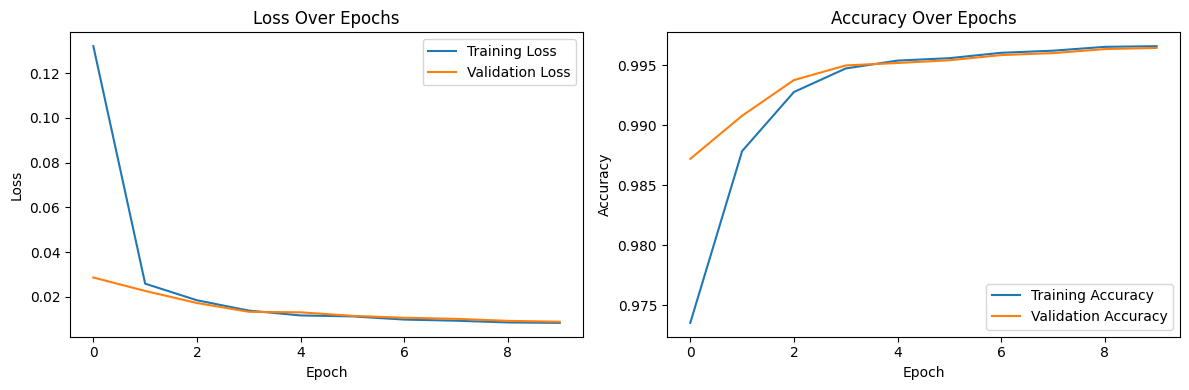

In [ ]:
def plot_training_history(history):
    # Plotting the Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(results)


### 6.2 Second Appraoch: Training with enhanced Dataset


In [ ]:
model_with_enhanced_dataset = build_3d_unet(input_shape, num_classes)
model_with_enhanced_dataset.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with early stopping and learning rate reduction on plateau
results_with_enhanced_dataset = model_with_enhanced_dataset.fit(
    x=np.array(images_processed),
    y=np.array(one_hot_encoded_masks),
    batch_size=2,
    validation_split=0.1,
    epochs=10,)  # Increased epochs due to early stopping

Epoch 1/10
117/117 [==============================] - 30s 193ms/step - loss: 0.1163 - accuracy: 0.9765 - val_loss: 0.0292 - val_accuracy: 0.9872
Epoch 2/10
117/117 [==============================] - 22s 184ms/step - loss: 0.0272 - accuracy: 0.9875 - val_loss: 0.0261 - val_accuracy: 0.9872
Epoch 3/10
117/117 [==============================] - 21s 178ms/step - loss: 0.0194 - accuracy: 0.9913 - val_loss: 0.0182 - val_accuracy: 0.9928
Epoch 4/10
117/117 [==============================] - 21s 179ms/step - loss: 0.0148 - accuracy: 0.9941 - val_loss: 0.0152 - val_accuracy: 0.9943
Epoch 5/10
117/117 [==============================] - 21s 181ms/step - loss: 0.0127 - accuracy: 0.9949 - val_loss: 0.0128 - val_accuracy: 0.9950
Epoch 6/10
117/117 [==============================] - 21s 181ms/step - loss: 0.0111 - accuracy: 0.9955 - val_loss: 0.0119 - val_accuracy: 0.9952
Epoch 7/10
117/117 [==============================] - 21s 179ms/step - loss: 0.0102 - accuracy: 0.9959 - val_loss: 0.0104 - val_ac

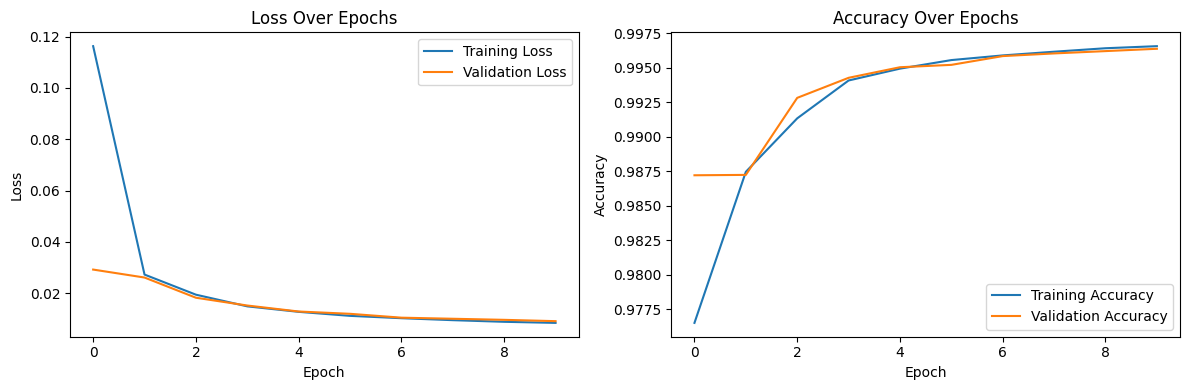

In [ ]:
plot_training_history(results_with_enhanced_dataset)

In [ ]:
model.save('model.h5')
model_with_enhanced_dataset.save('model_with_enhanced_dataset.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. Prediction

In [ ]:
# Assuming your model is named 'my_model.h5'
#model = load_model('/content/model.h5')

# Load the image you want to predict on
nifti_img = nib.load('/content/drive/MyDrive/Hippocampus/Task04_Hippocampus/imagesTs/hippocampus_002.nii.gz')
image_data = nifti_img.get_fdata()

# Preprocess the image
padded_image = pad_volume_to_target_shape(image_data, target_shape=(64, 64, 64))
contrast_enhanced_image = apply_clahe_and_normalize(padded_image)

# Add the batch and channel dimensions
contrast_enhanced_image = np.expand_dims(contrast_enhanced_image, axis=0)
contrast_enhanced_image = np.expand_dims(contrast_enhanced_image, axis=-1)

# Make the prediction
predicted_mask = model.predict(contrast_enhanced_image)

# Convert one-hot encoded mask to a label map if necessary
predicted_mask = np.argmax(predicted_mask, axis=-1)

1/1 [==============================] - 1s 1s/step


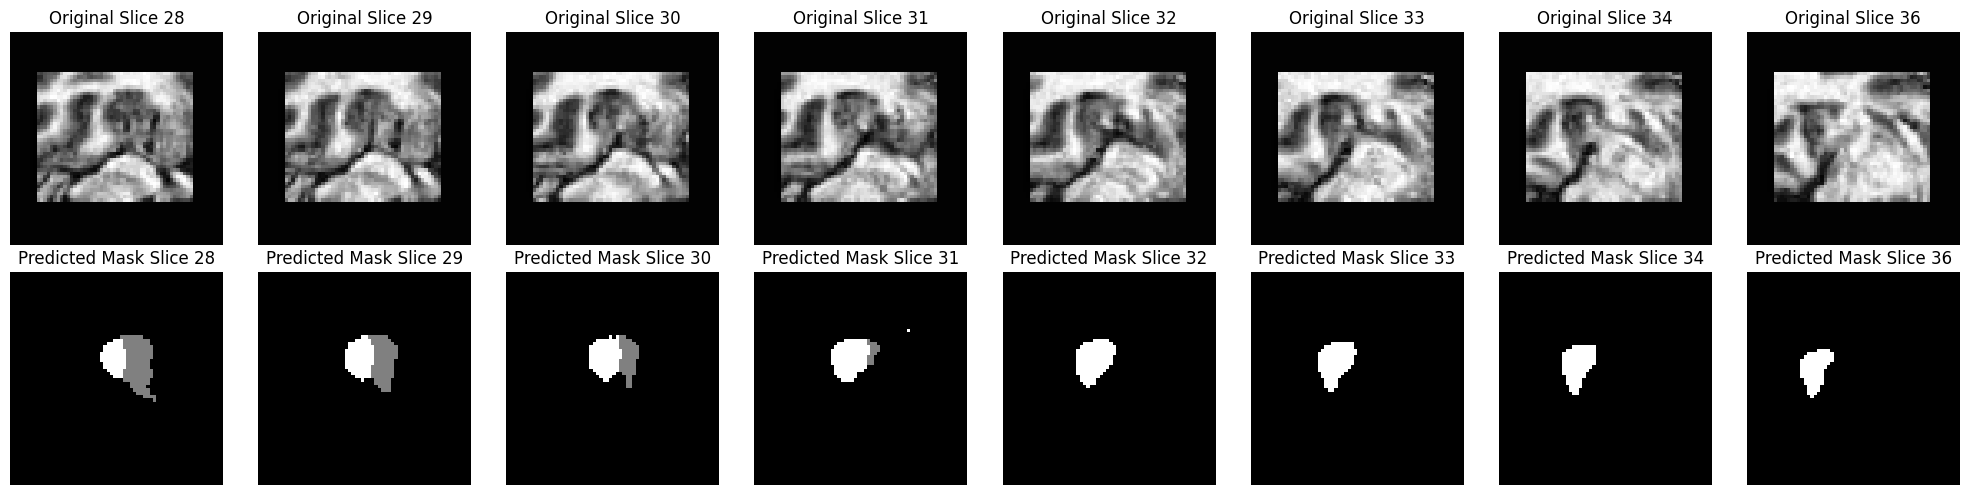

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(volume, predicted_mask, num_slices=8):
    """
    Visualize central slices from the original volume with the predicted mask overlay.

    Parameters:
    - volume: numpy.ndarray, the original 3D volume.
    - predicted_mask: numpy.ndarray, the predicted mask volume.
    - num_slices: int, the number of central slices to visualize.
    """
    # Calculate the middle slice index and get equally spaced slices around it
    mid_slice_idx = volume.shape[2] // 2
    slice_indices = np.linspace(
        max(mid_slice_idx - num_slices // 2, 0),
        min(mid_slice_idx + num_slices // 2, volume.shape[2] - 1),
        num_slices, dtype=int
    )

    fig, axes = plt.subplots(2, num_slices, figsize=(20, 5))
    for i, slice_idx in enumerate(slice_indices):
        # Display original image slice
        axes[0, i].imshow(volume[:, :, slice_idx], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original Slice {slice_idx}')

        # Display predicted mask slice
        axes[1, i].imshow(predicted_mask[:, :, slice_idx], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Predicted Mask Slice {slice_idx}')

    plt.tight_layout()
    plt.show()

# Your code to squeeze the dimensions
predicted_mask_squeezed = predicted_mask.squeeze()
normalized_image_squeezed = contrast_enhanced_image.squeeze()

# Call the visualization function
visualize_prediction(normalized_image_squeezed, predicted_mask_squeezed, num_slices=8)


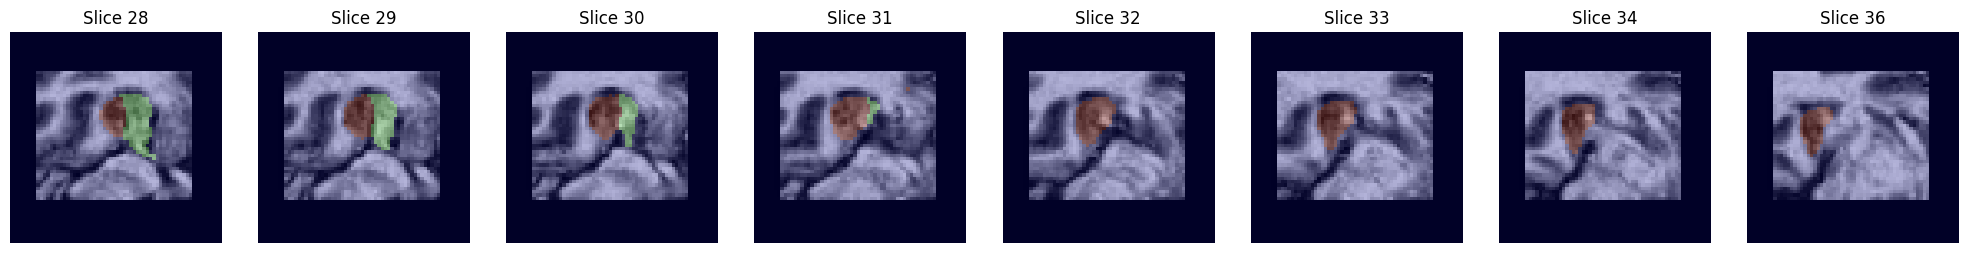

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_overlay(volume, predicted_mask, num_slices=8, alpha=0.3):
    """
    Visualize central slices from the original volume with the predicted mask overlay.

    Parameters:
    - volume: numpy.ndarray, the original 3D volume.
    - predicted_mask: numpy.ndarray, the predicted mask volume.
    - num_slices: int, the number of central slices to visualize.
    - alpha: float, the transparency level of the overlay.
    """
    # Calculate the middle slice index and get equally spaced slices around it
    mid_slice_idx = volume.shape[2] // 2
    slice_indices = np.linspace(
        max(mid_slice_idx - num_slices // 2, 0),
        min(mid_slice_idx + num_slices // 2, volume.shape[2] - 1),
        num_slices, dtype=int
    )

    fig, axes = plt.subplots(1, num_slices, figsize=(20, 2.5))
    for i, slice_idx in enumerate(slice_indices):
        # Display original image slice
        axes[i].imshow(volume[:, :, slice_idx], cmap='gray')

        # Overlay predicted mask slice
        mask = predicted_mask[:, :, slice_idx]
        axes[i].imshow(mask, cmap='jet', alpha=alpha)  # Use an appropriate colormap
        axes[i].axis('off')
        axes[i].set_title(f'Slice {slice_idx}')

    plt.tight_layout()
    plt.show()

visualize_overlay(normalized_image_squeezed, predicted_mask_squeezed, num_slices=8)
